In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Style Settings
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 12

In [17]:
# Load Data
# 'parse_dates' so pd recognizes the text as actual time
# 'index_col' so time is our reference index, not row numbers
df = pd.read_csv('data/PJME_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df = df.sort_index()

In [18]:
# Inspect Data
print("Top 5 rows:")
print(df.head())

Top 5 rows:
                     PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0


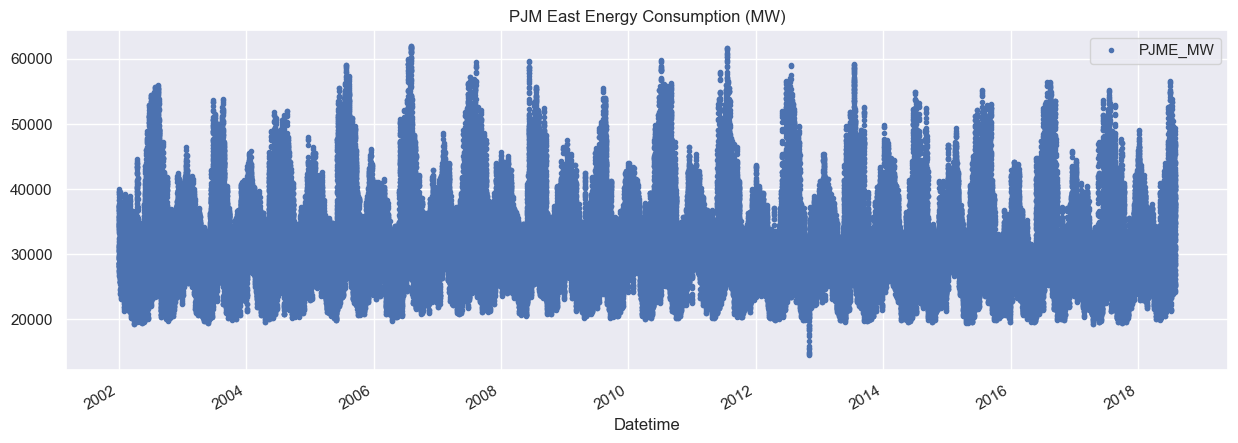

In [19]:
# Visualize Data
# Plot entire history to see overall trends
df.plot(style='.', title='PJM East Energy Consumption (MW)')
plt.show()

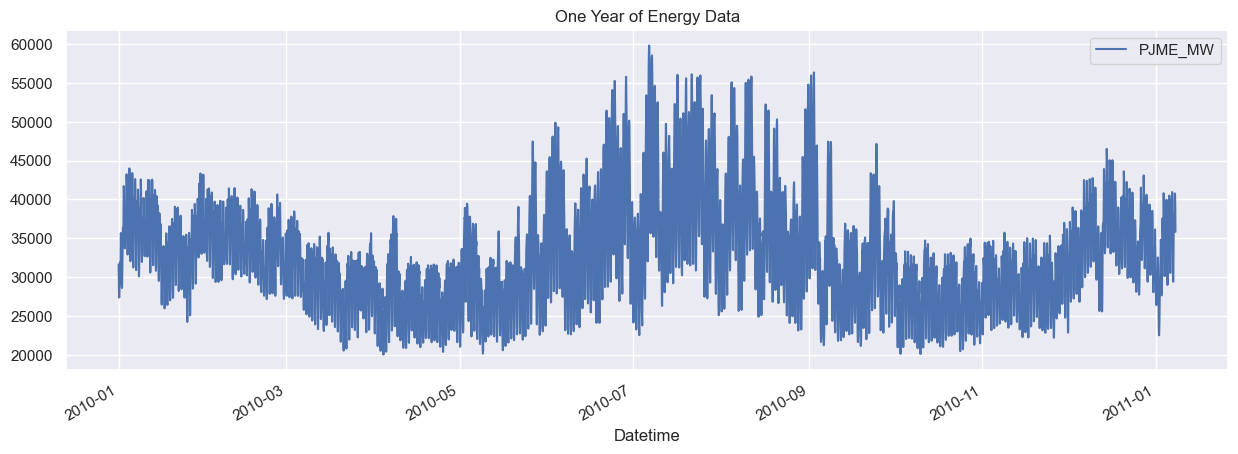

In [21]:
# Zoom In
# Plot a specific year to see seasonal patterns
df.loc["2010-01-01":"2011-01-07"].plot(title="One Year of Energy Data")
plt.show()

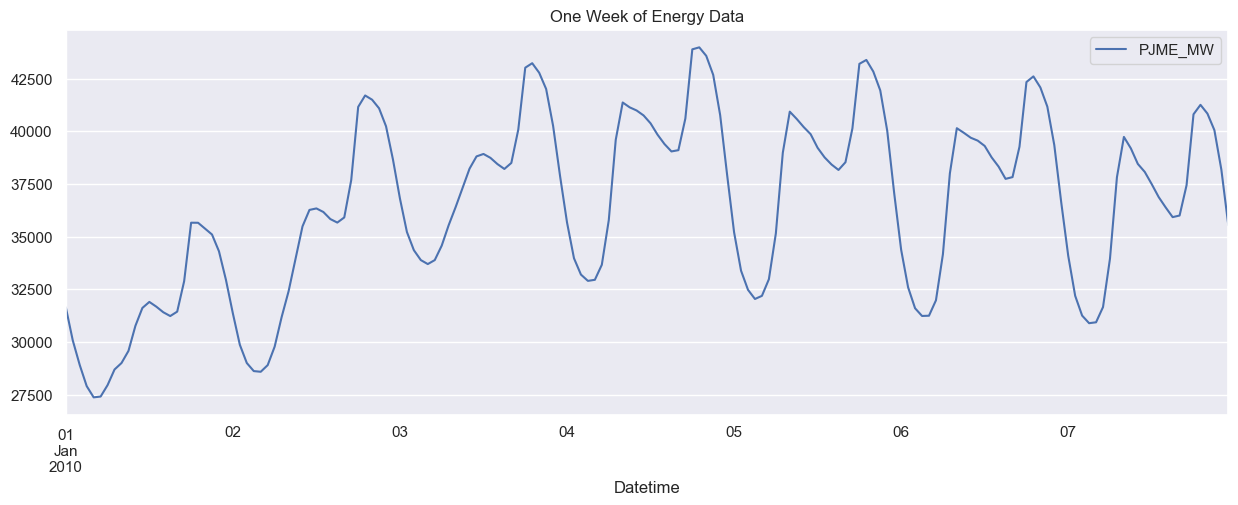

In [ ]:
# Zoom In
# Plot a specific week to see seasonal patterns
df.loc["2010-01-01":"2010-01-07"].plot(title="One Week of Energy Data")
plt.show()

# Pattern Insight

* Year over Year is consistent
* Summer months use the most energy
* Spring and Fall use the least
* Each day has 2 peaks and 1 large dip

# Train Test Split

* Training = Everything before 2015
* Testing = Everything after 2015

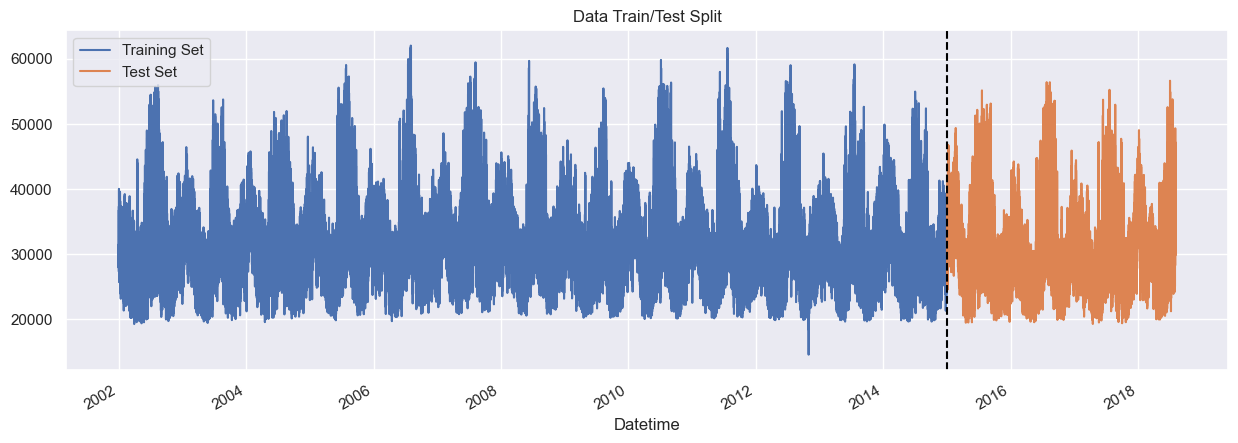

In [22]:
# Train test split
split_date = '2015-01-01'

train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Visualize the split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
plt.legend(['Training Set', 'Test Set'])
plt.show()